## Init

In [1]:
import torch
import numpy as np
from torch import optim
from torch import nn

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

CUDA = False

## Main meta parameters

In [2]:
NOISE_REG = 0.03
INPUT_DEPTH = 32
NUM_STEPS = 2500
SHOW_STEP = 50
LR = 0.01
DTYPE = torch.cuda.FloatTensor if CUDA else torch.FloatTensor
MAX_DIM = 128
PLOT_RESULT = True

## Neural network architecture

#### Blocks

In [3]:
class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)

class ConvBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=1, padding=0, bias=False):
        super(ConvBlock2d, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(int((kernel_size-1) / 2)),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, 0, bias=bias), #separable depthwise/pointwise ???
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
            )

    def forward(self, x):
        return self.model(x)

#### Net

In [4]:
class Generator(nn.Module):
    def __init__(self, input_channels, num_of_down_channels = 5*[128], num_of_up_channels = 5*[128], num_of_skip_channels = 5*[4]):
        super(Generator, self).__init__()

        network_depth = len(num_of_down_channels)

        # we need to check if given parameters are feasible
        # asserty i inne gówna

        # creating network structure
        self.model = nn.Sequential()
        main_model = self.model # main model (in current loop iteraion), we connect all deeper layers to this module every iteration

        for i in range(network_depth):

            deeper = nn.Sequential() # all of the deeper part of the network
            skip = nn.Sequential() # skip module, deeper+skip -> upper part of network

            if num_of_skip_channels[i] > 0:
                main_model.add_module('concat_'+str(i), Concat(1, skip, deeper))
            else:
                main_model.add_module('down_'+str(i), deeper)

            next_channels = num_of_up_channels[i + 1] if i < network_depth - 1 else num_of_down_channels[i]

            # batch norm on skip connection and upsample
            main_model.add_module('batchnorma_'+str(i), nn.BatchNorm2d(num_of_skip_channels[i] + next_channels))

            # convolution on skip connection
            if num_of_skip_channels[i]:
                skip.add_module('skipconv_'+str(i), ConvBlock2d(in_channels=input_channels, out_channels=num_of_skip_channels[i], stride=1, kernel_size=1))

            # convolution and downsample layers
            deeper.add_module('downsample_'+str(i), ConvBlock2d(in_channels=input_channels, out_channels=num_of_down_channels[i], stride=2, kernel_size=3))
            deeper.add_module('downconv_'+str(i), ConvBlock2d(in_channels=num_of_down_channels[i], out_channels=num_of_down_channels[i], stride=1, kernel_size=3))

            deeper_main = nn.Sequential() # all the i+1. i+2, ..., network_depth levels of U-shaped network that we create over the iteration of loop

            if i < network_depth: # we still go deeper
                deeper.add_module('deeperlvl_'+str(i), deeper_main)

            # upsample
            deeper.add_module('upsample_'+str(i), nn.Upsample(scale_factor=2, mode='nearest'))

            # convolution after during upsampling (after deepest point of network)
            main_model.add_module('upconv_'+str(i), ConvBlock2d(in_channels=num_of_skip_channels[i] + next_channels, out_channels=num_of_up_channels[i], stride=1, kernel_size=3))
            main_model.add_module('upconv1x1_'+str(i), ConvBlock2d(in_channels=num_of_up_channels[i], out_channels=num_of_up_channels[i], stride=1, kernel_size=1)) # optional recomended 1x1 conv

            input_channels = num_of_down_channels[i] # level lower, changing size of current input
            main_model = deeper_main # all deeper levels created over the iteration

        # last convolution layer and activation function
        self.model.add_module('upconv_'+str(network_depth), nn.Conv2d(in_channels=num_of_up_channels[0], out_channels=3, stride=1, kernel_size=1))
        self.model.add_module('sigmoid', nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

## Utils functions

In [5]:
def open_imgs(watermark_path, photo_path):
    watermark_pil = Image.open(watermark_path).convert('RGB')
    photo_pil = Image.open(photo_path).convert('RGB')
    return watermark_pil, photo_pil

def resize_img(img_pil):
    img_pil.thumbnail((MAX_DIM, MAX_DIM), Image.ANTIALIAS)

def pil_to_np(x):
    x = np.array(x)
    x = x.transpose(2,0,1)
    return x.astype(np.float32) / 255.

def np_to_pil(x):
    return Image.fromarray((x * 255.).transpose(1,2,0).astype('uint8'), 'RGB')

def tensor_to_np(x):
    return x.detach().cpu().numpy()

def np_to_tensor(x):
    return torch.from_numpy(x)[None, :]

def generate_noise(depth, size, noise_type, factor=0.1):
    if noise_type == 'normal':
        return torch.randn(1, depth, size[0], size[1]) * factor
    elif noise_type == 'uniform':
        return torch.rand(1, depth, size[0], size[1]) * factor

## Process input images

In [7]:
watermark_pil, photo_pil = open_imgs('/home/maurykdell/Desktop/university/S5/AdvancedPython/photothief/experiments/exp1/watermark.png', '/home/maurykdell/Desktop/university/S5/AdvancedPython/photothief/experiments/exp1/watermarked.png')
resize_img(watermark_pil)
resize_img(photo_pil)
watermark_np = pil_to_np(watermark_pil)
photo_np = pil_to_np(photo_pil)
watermark_var = np_to_tensor(watermark_np).type(DTYPE)
photo_var = np_to_tensor(photo_np).type(DTYPE)

## Initializing model, optimizer, loss etc.

In [8]:
generator = Generator(
    input_channels=INPUT_DEPTH,
    num_of_down_channels = 5*[128],
    num_of_up_channels = 5*[128],
    num_of_skip_channels = 5*[5]
    ).type(DTYPE)
mse = torch.nn.MSELoss().type(DTYPE)
optimizer = optim.Adam(generator.parameters(), lr=LR)
gen_input = generate_noise(INPUT_DEPTH, photo_pil.size[::-1], 'uniform').type(DTYPE)
gen_input_og = gen_input.detach().clone()
noise = gen_input.detach().clone()

## Main loop

iter: 0   loss: 0.005153529811650515


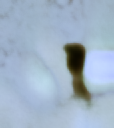

iter: 50   loss: 0.003025477286428213


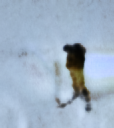

iter: 100   loss: 0.0022804499603807926


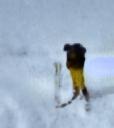

iter: 150   loss: 0.0015801511472091079


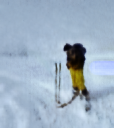

KeyboardInterrupt: 

In [11]:
for i in range(NUM_STEPS + 1):
    optimizer.zero_grad()

    gen_input = gen_input_og + (noise.normal_() * NOISE_REG) # add noise regularization as in paper

    output = generator(gen_input)

    loss = mse(output * watermark_var, photo_var)
    loss.backward()
    loss_values.append(loss.item())
    # show current result
    if i % SHOW_STEP == 0:
        print(f'iter: {i}   loss: {loss.item()}')
        curr_pil = np_to_pil(tensor_to_np(output)[0])
        display(curr_pil)

    optimizer.step()